# Load libraries, define folders

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob 
import os
from scipy import stats
from statsmodels.stats import multitest
dataFolder = 'flowCytometry/'
sns.set_style("white")
sns.set_style("ticks")
colormap = 'colorblind'
colors = sns.color_palette(colormap, 8)
segments = ['PB1_vRNA','HA_vRNA','PB2_vRNA',  'PA_vRNA','NP_vRNA','NA_vRNA','M_vRNA','NS_vRNA']
fluColors = {}
for color, segment in enumerate(segments):
    fluColors[segment] = colors[color]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})

HA staining using H17-L19 at MOI of 0.1 as calculated by TCID50 on MDCK-SIAT1 cells. Staining 9h post infection. True biological replicates of all populations shown.
Early staining so probably underestimate of infections.

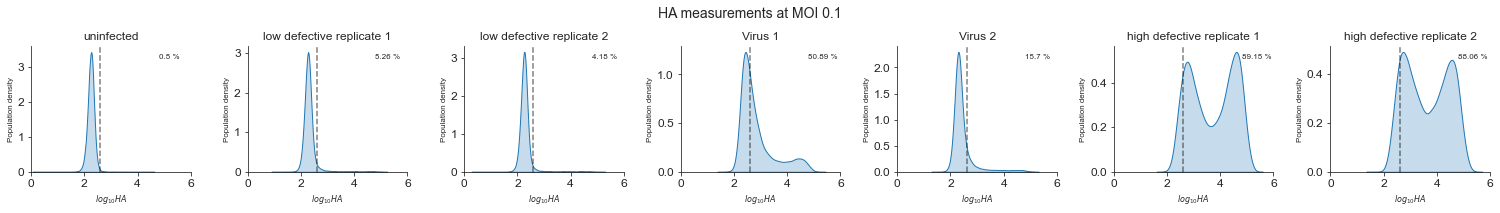

In [3]:
data = []
for file in glob.glob(dataFolder + 'HA_MOI_01/*.csv'):
    currFrame = pd.read_csv(file)
    currFrame['sample'] = os.path.basename(file.split('.')[0])
    data += [currFrame]
data = pd.concat(data)
    
    


Fluors = {'PerCP-Cy5-5-A':'HA'}
control = 'uninfected'
populations = ['uninfected', 'low_defective_replicate_1', 'low_defective_replicate_2','Virus_1','Virus_2','high_defective_replicate_1','high_defective_replicate_2']
samples = []
plt.figure(1, (21, 3))
plt.suptitle('HA measurements at MOI 0.1', fontsize = 14)
#5 in 1000 should be an ok threshold
gatethresh = 0.995
for key, value in Fluors.items():
    #scoot all data over to be >0.
    scootVal = -(data[data[key] <0][key].min()) + data[data[key] > 0][key].min()
    data[value] = np.log10(data[key] + scootVal)

#set gates
HAthresh =  data[data['sample'] == control].HA.quantile(gatethresh)
data['HApos'] = data.HA > HAthresh
x = 171

for sample in populations:
    plotFrame = data[data['sample'] == sample]
    ax = plt.subplot(x)
    sns.kdeplot(data = plotFrame.HA, shade=True, ax = ax, legend=False)
    plt.title(sample.replace('_', ' '), fontsize = 12)
    plt.xlabel("$log_{10}{HA}$", fontsize=8)
    plt.ylabel("Population density", fontsize=8)
    sns.despine()
    plt.axvline(HAthresh, color = 'k',ls = '--', alpha =0.5)
    ax.text(0.8, 0.9, str(round(plotFrame.mean().HApos*100, 2)) + ' %' , fontsize=8, transform=ax.transAxes)

    plt.xlim(0,6)
    x += 1

plt.tight_layout()
plt.subplots_adjust(top = 0.8)
plt.savefig('Figures/HAdist_defective.pdf', format='pdf', bbox_inches = "tight")


Complementation experiments. 13h post infection stained. MOI 0.5. Gating strategy for supplement. Only one variable so just show as population distribution on 1 dimension.

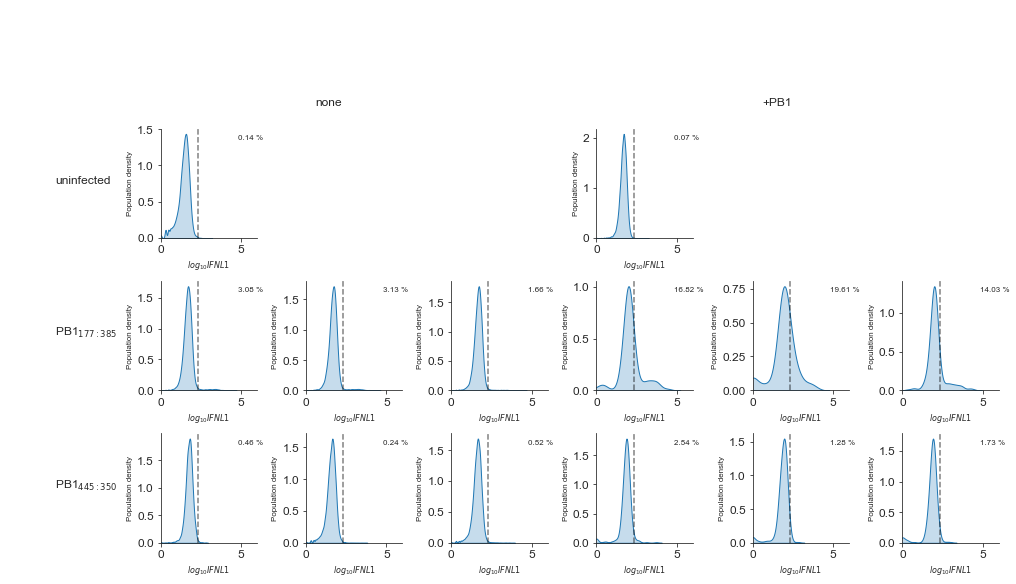

In [4]:
data = []
for file in glob.glob(dataFolder + 'PB1_complementation/*.tsv'):
    currFrame = pd.read_csv(file, sep='\t')
    population, treatment, replicate = os.path.basename(file.split('.')[0]).split('_')
    currFrame['sample'] = population
    currFrame['treatment'] = treatment
    currFrame['replicate'] = replicate
    data += [currFrame]
data = pd.concat(data).rename(columns={'IFNL1-A':'IFNL1'})
popOrder = ['uninfected',  'PB1177385', 'PB1445350']
nameOrder = ['uninfected', 'PB1$_{177:385}$', 'PB1$_{445:350}$']
treatmentOrder = ['none', '+PB1']
replicates = ['1','2','3']
gatethresh = 0.999

#log transform
if data.IFNL1.min() < 0:
    scootVal = -(data[data.IFNL1 <0].IFNL1.min()) + data[data.IFNL1 > 0].IFNL1.min()
    data['IFNL1'] = np.log10(data.IFNL1 + scootVal)
else:
    data['IFNL1'] = np.log10(data.IFNL1)

IFNL1thresh = data[data['sample'] == 'uninfected'].IFNL1.quantile(gatethresh)
data['IFNL1_positive'] = data.IFNL1 > IFNL1thresh

rows = len(popOrder) + 1
columns = len(treatmentOrder) * len(replicates) + 1
g = plt.figure(1, (columns*2, rows*2), constrained_layout=True)
spec = g.add_gridspec(rows,columns)
#first row just write out treatments
currCol = 0
for column, treatment in enumerate(treatmentOrder):
    while currCol < (3*(column) + 2):
        ax = g.add_subplot(spec[0, currCol])
        ax.axis('off')
        currCol += 1
    ax = g.add_subplot(spec[0, currCol])
    ax.axis('off')
    ax.text(0.1, 0.1, treatment, transform=ax.transAxes, fontsize=12)
    currCol +=1
while currCol < columns:
    ax = g.add_subplot(spec[0, currCol])
    ax.axis('off')
    currCol +=1
    
    
currRow = 0
currCol = 0
for name, population in enumerate(popOrder):
    currRow +=1
    currCol = 0
    ax = g.add_subplot(spec[currRow,currCol])
    ax.axis('off')
    ax.text(0.5, 0.5, nameOrder[name], transform=ax.transAxes, fontsize=12)
    currCol += 1
    for treatment in treatmentOrder:
        for replicate in replicates:
            ax = g.add_subplot(spec[currRow,currCol])
            currFrame = data[(data['sample'] == population) & (data.replicate == replicate) & (data.treatment == treatment)]
            if len(currFrame) == 0:
                ax.axis('off')
            else:
                sns.kdeplot(data = currFrame.IFNL1, shade=True, ax = ax, legend=False)
                plt.xlabel("$log_{10}{IFNL1}$", fontsize=8)
                plt.ylabel("Population density", fontsize=8)
                sns.despine()
                plt.axvline(IFNL1thresh, color = 'k',ls = '--', alpha =0.5)
                ax.text(0.8, 0.9, str(round(currFrame.mean().IFNL1_positive*100, 2)) + ' %' , fontsize=8, transform=ax.transAxes)
                plt.xlim(0,6)
            currCol+=1

plt.savefig('Figures/IFNL1dist_complement.pdf', format='pdf', bbox_inches = "tight")


Summary of fraction IFN+ (whole population.)

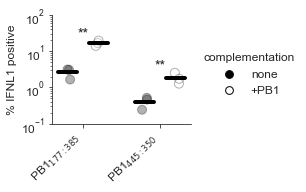

In [5]:

graph = data.groupby(['sample', 'replicate', 'treatment']).IFNL1_positive.mean().reset_index()
graph['IFNL1_positive'] = graph.IFNL1_positive * 100
g, ax = plt.subplots( 1,1, figsize=(2.5,2))
graph = graph[graph['sample'] != 'uninfected']
order = [ 'PB1177385', 'PB1445350']
nameOrder = ['PB1$_{177:385}$', 'PB1$_{445:350}$']

ax=sns.stripplot(x='sample', y='IFNL1_positive', data=graph,  edgecolor='black', order = order,
            jitter=True, dodge=True, linewidth=1, s=9, hue="treatment", hue_order=['none','+PB1'],palette=['0','1'], alpha = 0.3)
ax.set_yscale('log')
ax.set_ylim(0.1,100)
sns.despine()

plt.xlabel('')
ax.legend(bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.,frameon=False, title='complementation')

plt.ylabel('% IFNL1 positive')
a =plt.xticks(np.arange(0,2,1),nameOrder,rotation=45, ha='right')



for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')

#stats on effect of complementation
pvals = []
for position, strain in enumerate(order):
    curr = graph[graph['sample'] == strain]
    tstat, pval = stats.ttest_ind(curr[curr.treatment == 'none'].IFNL1_positive, curr[curr.treatment == '+PB1'].IFNL1_positive )
    pvals += [pval]
    y = curr[curr.treatment == 'none'].IFNL1_positive.mean()
    plt.plot([position-0.325, position-0.075], [y, y], lw=4, c='k', zorder=9)
    y = curr[curr.treatment == '+PB1'].IFNL1_positive.mean()
    plt.plot([position+0.075, position+0.325], [y, y], lw=4, c='k', zorder=9)
    
pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
for position, val in enumerate(pvals):
    if val:
        y = graph[graph['sample'] == order[position]].IFNL1_positive.max()
        plt.text(position, y, "**", ha='center', va='bottom', fontsize=14)
plt.savefig('Figures/complementAnalysis.pdf', format='pdf', bbox_inches = "tight")


Exploring complementation of stimulatory PB1 deletion more. MOI 0.5, stained for HA, with and without complementation, then facet on degree of HA staining. First, show gating schema. Go ahead and show 2 dimensions now, show spots. Downsample to 5000 events. Leave off fractions for this supplement as they are a bit misleading with respect to relative densities.

Could use topology, or color by density, but as this is for supplement a little bit of overplotting isn't the end of the world. Would want to alter if the point was to show anything beyond a scarcity of points beyond certain gates.

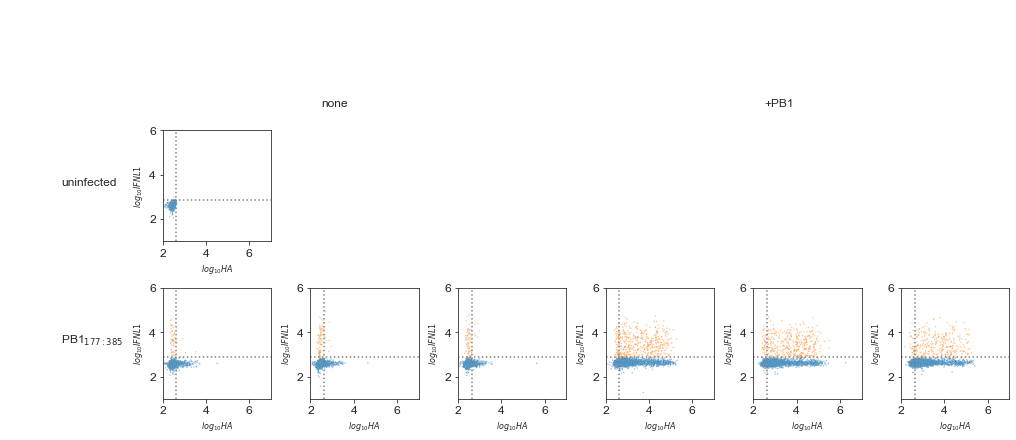

In [6]:
data = []
for file in glob.glob(dataFolder + 'PB1_complementation_HAstain/*.csv'):
    currFrame = pd.read_csv(file)
    population, treatment, replicate = os.path.basename(file.split('.')[0]).split('_')
    currFrame['sample'] = population
    currFrame['treatment'] = treatment
    currFrame['replicate'] = replicate
    data += [currFrame]
gatethresh = 0.999
data = pd.concat(data) 
fluors = {'Comp-APC-A':'HA', 'Comp-FITC-A':'IFNL1'}
thresholds = {}
for key, value in fluors.items():
    #scoot all data over to be >0.
    if data[key].min() < 0:     
        scootVal = -(data[data[key] <0][key].min()) + data[data[key] > 0][key].min()
        data[value] = np.log10(data[key] + scootVal)
    else:
        data[value] = np.log10(data[key])
    thresholds[value] = data[data['sample'] == 'uninfected'][value].quantile(gatethresh)
    data[value + '_positive'] = data[value] > thresholds[value]


popOrder = ['uninfected',  'PB1177385']
nameOrder = ['uninfected', 'PB1$_{177:385}$']
treatmentOrder = ['none', '+PB1']
replicates = ['1','2','3']
rows = len(popOrder) + 1
columns = len(treatmentOrder) * len(replicates) + 1
g = plt.figure(1, (columns*2, rows*2), constrained_layout=True)
spec = g.add_gridspec(rows,columns)
#first row just write out treatments
currCol = 0
for column, treatment in enumerate(treatmentOrder):
    while currCol < (3*(column) + 2):
        ax = g.add_subplot(spec[0, currCol])
        ax.axis('off')
        currCol += 1
    ax = g.add_subplot(spec[0, currCol])
    ax.axis('off')
    ax.text(0.1, 0.1, treatment, transform=ax.transAxes, fontsize=12)
    currCol +=1
while currCol < columns:
    ax = g.add_subplot(spec[0, currCol])
    ax.axis('off')
    currCol +=1  
currRow = 0
currCol = 0
for name, population in enumerate(popOrder):
    currRow +=1
    currCol = 0
    ax = g.add_subplot(spec[currRow,currCol])
    ax.axis('off')
    ax.text(0.5, 0.5, nameOrder[name], transform=ax.transAxes, fontsize=12)
    currCol += 1
    for treatment in treatmentOrder:
        for replicate in replicates:
            ax = g.add_subplot(spec[currRow,currCol])
            currFrame = data[(data['sample'] == population) & (data.replicate == replicate) & (data.treatment == treatment)]
            if len(currFrame) == 0:
                ax.axis('off')
            else:
                sns.scatterplot(data = currFrame.sample(5000), x='HA', y='IFNL1',hue='IFNL1_positive', legend=False, rasterized=True, s=2, alpha=0.5)
                plt.xlabel("$log_{10}{HA}$", fontsize=8)
                plt.ylabel("$log_{10}{IFNL1}$", fontsize=8)
                ax.axvline(x = thresholds['HA'], c=".5", ls=":")
                ax.axhline(y = thresholds['IFNL1'], c=".5", ls=":")
                plt.ylim(1,6)
                plt.xlim(2,7)
            currCol+=1

plt.savefig('Figures/IFNL1_complement_stained_dist.pdf', format='pdf', bbox_inches = "tight")


So, looking at PB1 complemented alone, how does HA facet with interferon induction? Simple quantiles would be too uneven, but I do want at least 5% of the data to be in the highest so don't want to simply divide the maximum value and minimum into even bins as top bins would be too sparse. Each step will be everything between the indicated bin and the next one (or top). Round everything above 8th quantile down to 8th quantile. Describe fully in Figure legend to make sure there it is clear how these data were processed.

Line is 99th percentile of HA+ cells in uncomplemented cells to provide context.

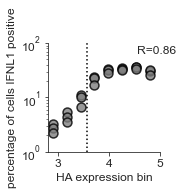

In [7]:
data = data[data.HA_positive]
primary = data[(data['sample'] ==  'PB1177385') & (data['treatment'] == 'none')].HA.quantile(0.99)
#divide whole range into 8ths from threshold to 99th percentile
maxVal = data[(data['sample'] ==  'PB1177385') & (data['treatment'] == '+PB1')].HA.quantile(0.95)
steps = (maxVal - thresholds['HA'])/7

data['expression_bin'] =  ((data.HA-thresholds['HA'])/steps).apply(np.ceil) 
#set top bin to the maxVal
data.loc[data.expression_bin > 8, 'expression_bin'] = 8
plot = data[(data['sample'] ==  'PB1177385') & (data['treatment'] == '+PB1')].groupby(['replicate', 'expression_bin']).mean().reset_index()
plot['HA'] = plot.expression_bin * steps + thresholds['HA']
plot['IFNL1 positive'] = plot.IFNL1_positive * 100
fig,ax = plt.subplots(figsize=(2,2))

sns.scatterplot(data=plot, x="HA", y="IFNL1 positive", color = '0.5', edgecolor='0',        
                linewidth=1.5, s=80, ax=ax, alpha=0.8)
plt.yscale('log')
plt.ylim(1,100)
plt.xlim(2.8,5)
sns.despine()
plt.axvline(x=primary, c='k',  ls=":")

plt.xlabel('HA expression bin')
a = plt.ylabel('percentage of cells IFNL1 positive')
spearman = round(plot.corr('spearman')['IFNL1_positive']['HA'],2)
a = ax.text(0.8, 0.9, 'R=' + str(spearman), transform=ax.transAxes, fontsize=12)
plt.savefig('Figures/IFNL1_complement_quantile.pdf', format='pdf', bbox_inches = "tight")


Coinfection data. Have 3 datapoints here, (mCherry, HA, IFNL1). Lets go ahead and make 2d plots of mCherry and HA, and 1d of IFNL1 to show gating strategies. Don't worry about numbers here as the interpretation would be complex.

Infections were initiated at an MOI of 0.1 (PB1 deletion, wild-type), 0.5 (mCherry), or 0.1 and 0.5 at the same time (wild-type or PB1 deletion, and mCherry, respectively).

Slightly higher gating thresholds

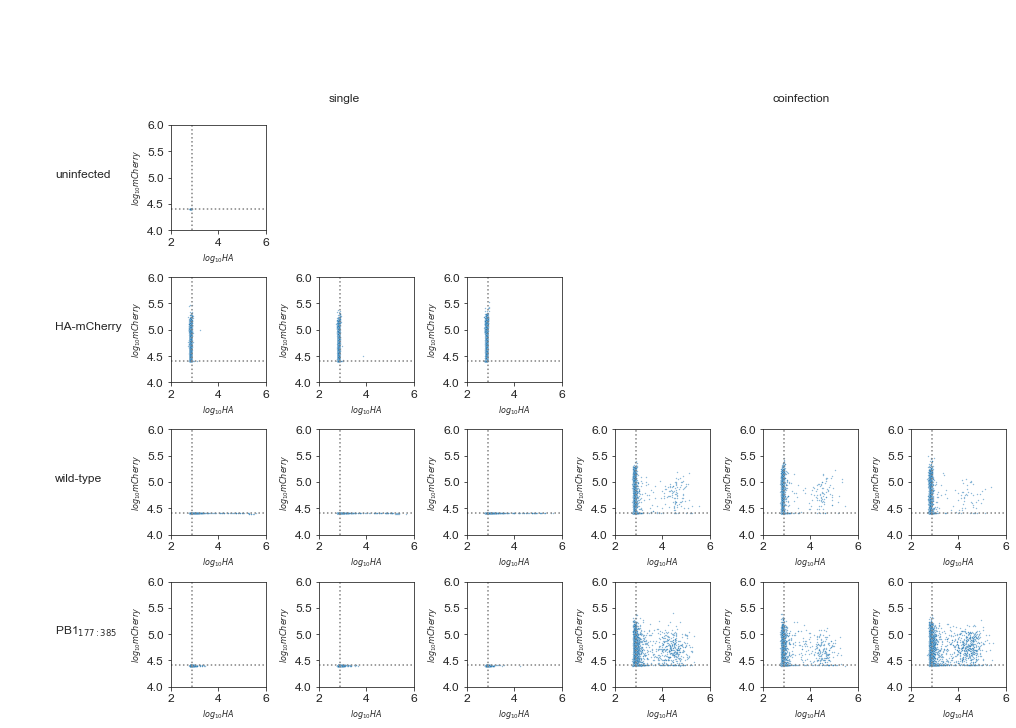

In [8]:
data = []
for file in glob.glob(dataFolder + 'mCherry_coinfection/*.csv'):
    currFrame = pd.read_csv(file)
    population, treatment, replicate = os.path.basename(file.split('.')[0]).split('_')
    currFrame['sample'] = population
    currFrame['treatment'] = treatment
    currFrame['replicate'] = replicate
    data += [currFrame]
gatethresh = 0.9995
data = pd.concat(data) 
fluors = {'Comp-APC-A':'HA', 'Comp-FITC-A':'IFNL1', 'Comp-PE-Texas Red-A':'mCherry'}
thresholds = {}
for key, value in fluors.items():
    #scoot all data over to be >0.
    if data[key].min() < 0:     
        scootVal = -(data[data[key] <0][key].min()) + data[data[key] > 0][key].min()
        data[value] = np.log10(data[key] + scootVal)
    else:
        data[value] = np.log10(data[key])
    thresholds[value] = data[data['sample'] == 'uninfected'][value].quantile(gatethresh)
    data[value + '_positive'] = data[value] > thresholds[value]


popOrder = ['uninfected','mCherry', 'wild-type', 'PB1177385']
nameOrder = ['uninfected','HA-mCherry', 'wild-type', 'PB1$_{177:385}$']
treatmentOrder = ['single', 'coinfection']
replicates = ['1','2','3']
rows = len(popOrder) + 1
columns = len(treatmentOrder) * len(replicates) + 1
g = plt.figure(1, (columns*2, rows*2), constrained_layout=True)
spec = g.add_gridspec(rows,columns)
#first row just write out treatments
currCol = 0
for column, treatment in enumerate(treatmentOrder):
    while currCol < (3*(column) + 2):
        ax = g.add_subplot(spec[0, currCol])
        ax.axis('off')
        currCol += 1
    ax = g.add_subplot(spec[0, currCol])
    ax.axis('off')
    ax.text(0.1, 0.1, treatment, transform=ax.transAxes, fontsize=12)
    currCol +=1
while currCol < columns:
    ax = g.add_subplot(spec[0, currCol])
    ax.axis('off')
    currCol +=1  
currRow = 0
currCol = 0
for name, population in enumerate(popOrder):
    currRow +=1
    currCol = 0
    ax = g.add_subplot(spec[currRow,currCol])
    ax.axis('off')
    ax.text(0.5, 0.5, nameOrder[name], transform=ax.transAxes, fontsize=12)
    currCol += 1
    for treatment in treatmentOrder:
        for replicate in replicates:
            ax = g.add_subplot(spec[currRow,currCol])
            currFrame = data[(data['sample'] == population) & (data.replicate == replicate) & (data.treatment == treatment)]
            if len(currFrame) == 0:
                ax.axis('off')
            else:
                sns.scatterplot(data = currFrame.sample(5000), x='HA', y='mCherry', legend=False, rasterized=True, s=2, alpha=0.5)
                plt.xlabel("$log_{10}{HA}$", fontsize=8)
                plt.ylabel("$log_{10}{mCherry}$", fontsize=8)
                ax.axvline(x = thresholds['HA'], c=".5", ls=":")
                ax.axhline(y = thresholds['mCherry'], c=".5", ls=":")
                plt.ylim(4,6)
                plt.xlim(2,6)
            currCol+=1
plt.savefig('Figures/HA_mCherry_gating.pdf', format='pdf', bbox_inches = "tight")

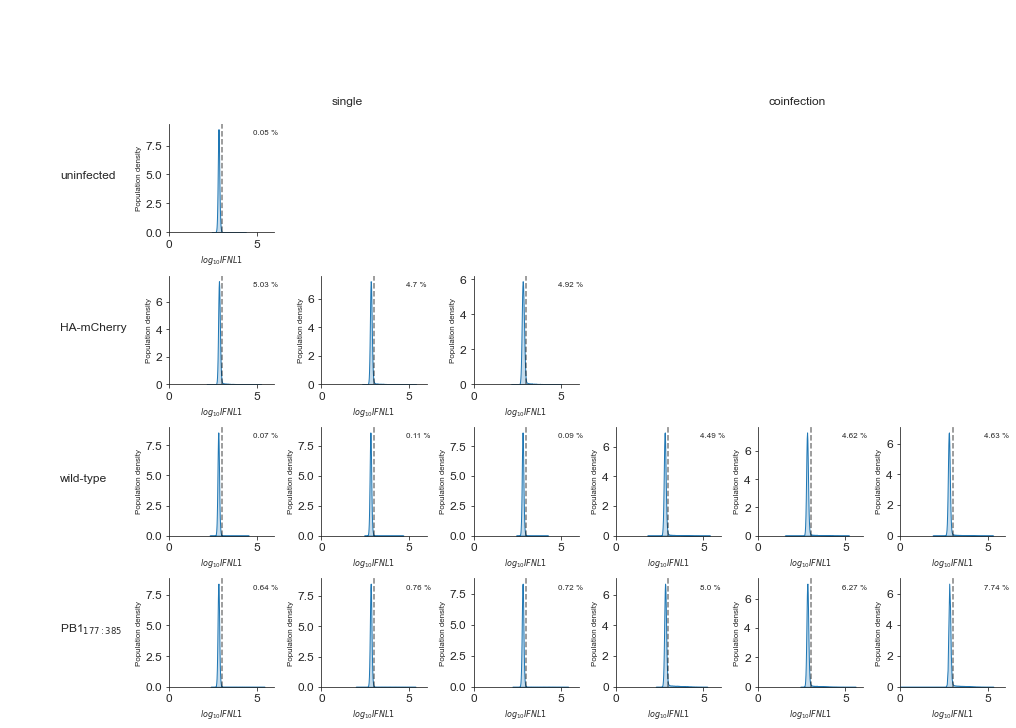

In [9]:
g = plt.figure(1, (columns*2, rows*2), constrained_layout=True)
spec = g.add_gridspec(rows,columns)
#first row just write out treatments
currCol = 0
for column, treatment in enumerate(treatmentOrder):
    while currCol < (3*(column) + 2):
        ax = g.add_subplot(spec[0, currCol])
        ax.axis('off')
        currCol += 1
    ax = g.add_subplot(spec[0, currCol])
    ax.axis('off')
    ax.text(0.1, 0.1, treatment, transform=ax.transAxes, fontsize=12)
    currCol +=1
while currCol < columns:
    ax = g.add_subplot(spec[0, currCol])
    ax.axis('off')
    currCol +=1  
currRow = 0
currCol = 0
for name, population in enumerate(popOrder):
    currRow +=1
    currCol = 0
    ax = g.add_subplot(spec[currRow,currCol])
    ax.axis('off')
    ax.text(0.5, 0.5, nameOrder[name], transform=ax.transAxes, fontsize=12)
    currCol += 1
    for treatment in treatmentOrder:
        for replicate in replicates:
            ax = g.add_subplot(spec[currRow,currCol])
            currFrame = data[(data['sample'] == population) & (data.replicate == replicate) & (data.treatment == treatment)]
            if len(currFrame) == 0:
                ax.axis('off')
            else:
                sns.kdeplot(data = currFrame.IFNL1, shade=True, ax = ax, legend=False)
                plt.xlabel("$log_{10}{IFNL1}$", fontsize=8)
                plt.ylabel("Population density", fontsize=8)
                sns.despine()
                plt.axvline(thresholds['IFNL1'], color = 'k',ls = '--', alpha =0.5)
                ax.text(0.8, 0.9, str(round(currFrame.mean().IFNL1_positive*100, 2)) + ' %' , fontsize=8, transform=ax.transAxes)
                plt.xlim(0,6)
            currCol+=1


plt.savefig('Figures/IFNL1_gating_coinfection.pdf', format='pdf', bbox_inches = "tight")

Restrict analysis to flu+ for single, HA+ mCherry+ for coinfection.

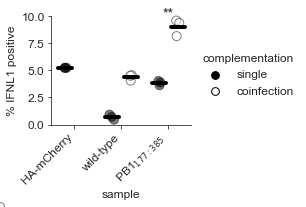

In [10]:
HAstain = ['wild-type', 'PB1177385']
mCherrystain = ['mCherry']
graph = []
for population in HAstain:
    graph += [data[(data['sample'] == population) & data.HA_positive & (data.treatment == 'single')]]
for population in mCherrystain:
    graph += [data[(data['sample'] == population) & data.mCherry_positive & (data.treatment == 'single')]]
graph += [data[(data.treatment == 'coinfection') & data.HA_positive & data.mCherry_positive]]
graph = pd.concat(graph)
order = ['mCherry', 'wild-type', 'PB1177385']
nameOrder = ['HA-mCherry', 'wild-type', 'PB1$_{177:385}$']
fig,ax = plt.subplots(figsize=(2.5,2))

graph = graph.groupby(['replicate','treatment','sample']).mean().reset_index()
graph['IFNL1_positive'] = graph.IFNL1_positive*100
sns.stripplot(x='sample', y='IFNL1_positive', data=graph,  edgecolor='black', order = order,
            jitter=True, dodge=True, linewidth=1, s=9, hue="treatment", hue_order=['single','coinfection'],palette=['0','1'], ax=ax, clip_on=False, alpha=0.5)
sns.despine()
plt.ylim(0,10)

ax.legend(bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.,frameon=False, title='complementation')

plt.ylabel('% IFNL1 positive')
a =plt.xticks(np.arange(0,3,1),nameOrder,rotation=45, ha='right')



for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')
        
#for stats run 2 tests, pass if flag for both. Is it significantly different than either single comparison Only perform 1-tailed test for greater than, not interested in suppressed
order = ['wild-type', 'PB1177385']
pvalCoinf = []
pvalSing = []
for position, strain in enumerate(order):
    curr = graph[graph['sample'] == strain]
    if (curr[curr.treatment == 'single'].IFNL1_positive.mean() < curr[curr.treatment == 'coinfection'].IFNL1_positive.mean()):
        tstat, pval = stats.ttest_ind(curr[curr.treatment == 'single'].IFNL1_positive, curr[curr.treatment == 'coinfection'].IFNL1_positive )
        pvalCoinf += [pval/2]
    else:
        pvalCoinf += [1]
    if (curr[curr.treatment == 'coinfection'].IFNL1_positive.mean() > graph[graph['sample'] == 'mCherry'].IFNL1_positive.mean()):
        tstat, pval = stats.ttest_ind(curr[curr.treatment == 'coinfection'].IFNL1_positive, graph[graph['sample'] == 'mCherry'].IFNL1_positive )
        pvalSing += [pval/2]
    else:
        pvalSing += [1]
    y = curr[curr.treatment == 'single'].IFNL1_positive.mean()
    plt.plot([position+ 1-0.35, position+1-0.05], [y, y], lw=4, c='k', zorder=8)
    y = curr[curr.treatment == 'coinfection'].IFNL1_positive.mean()
    plt.plot([position+1+0.05, position+1+0.35], [y, y], lw=4, c='k', zorder=8, clip_on=False)    
y = graph[(graph.treatment == 'single') & (graph['sample'] == 'mCherry')].IFNL1_positive.mean()
plt.plot([-0.35, -0.05], [y, y], lw=4, c='k', zorder=8)


pvals = pvalSing + pvalCoinf
pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
#require two true
pvals = pvals[:len(pvalSing)] & pvals[-len(pvalCoinf):]
for position, val in enumerate(pvals):
    if val:
        y = graph[graph['sample'] == order[position]].IFNL1_positive.max()
        plt.text(position + 1, y, "**", ha='center', va='bottom', fontsize=14)
plt.savefig('Figures/coinfection.pdf', format='pdf', bbox_inches = "tight")

Lastly, testing the effect of MOI on fraction positive between high defective and pure populations. Genome-matched MOI of 0.1 and 2. Used qPCR against genomes to normalized, and MOI based on TCID50 using low defective population. Measurements 13h post infection as in others.

Gating thresholds for interferon and HA

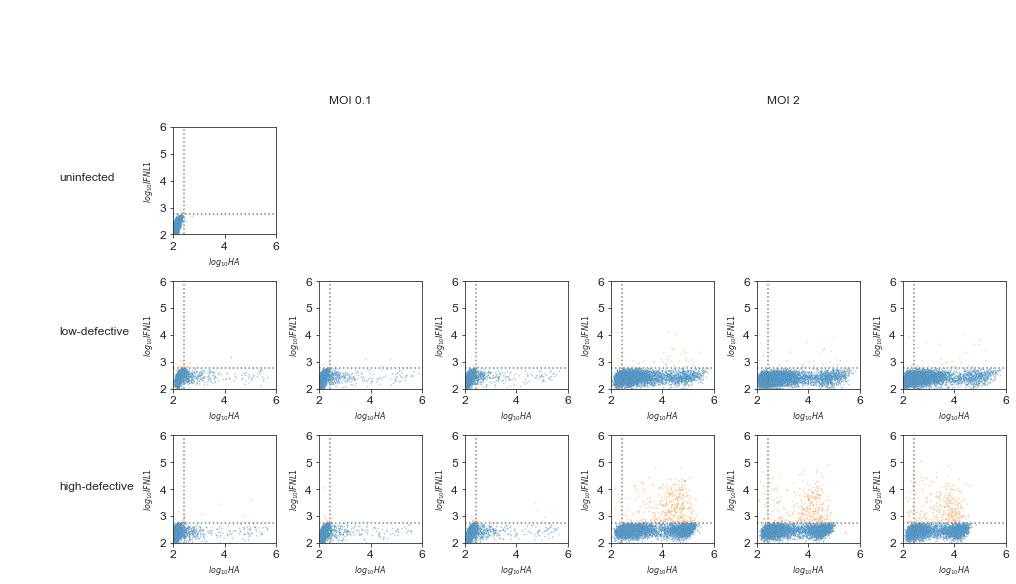

In [11]:
data = []
for file in glob.glob(dataFolder + 'MOI_defective/*.csv'):
    currFrame = pd.read_csv(file)
    population, treatment, replicate = os.path.basename(file.split('.')[0]).split('_')
    currFrame['sample'] = population
    currFrame['treatment'] = treatment
    currFrame['replicate'] = replicate
    data += [currFrame]
gatethresh = 0.999
data = pd.concat(data) 
fluors = {'APC-A':'HA', 'FITC-A':'IFNL1'}
thresholds = {}
for key, value in fluors.items():
    #scoot all data over to be >0.
    if data[key].min() < 0:     
        scootVal = -(data[data[key] <0][key].min()) + data[data[key] > 0][key].min()
        data[value] = np.log10(data[key] + scootVal)
    else:
        data[value] = np.log10(data[key])
    thresholds[value] = data[data['sample'] == 'uninfected'][value].quantile(gatethresh)
    data[value + '_positive'] = data[value] > thresholds[value]


popOrder = ['uninfected','lowDI', 'HiDI']
nameOrder = ['uninfected','low-defective', 'high-defective']
treatmentOrder = ['Low', 'High']
treatmentName = ['MOI 0.1','MOI 2']
replicates = ['1','2','3']
rows = len(popOrder) + 1
columns = len(treatmentOrder) * len(replicates) + 1
g = plt.figure(1, (columns*2, rows*2), constrained_layout=True)
spec = g.add_gridspec(rows,columns)
#first row just write out treatments
currCol = 0
for column, treatment in enumerate(treatmentOrder):
    while currCol < (3*(column) + 2):
        ax = g.add_subplot(spec[0, currCol])
        ax.axis('off')
        currCol += 1
    ax = g.add_subplot(spec[0, currCol])
    ax.axis('off')
    ax.text(0.1, 0.1, treatmentName[column], transform=ax.transAxes, fontsize=12)
    currCol +=1
while currCol < columns:
    ax = g.add_subplot(spec[0, currCol])
    ax.axis('off')
    currCol +=1  
currRow = 0
currCol = 0
for name, population in enumerate(popOrder):
    currRow +=1
    currCol = 0
    ax = g.add_subplot(spec[currRow,currCol])
    ax.axis('off')
    ax.text(0.5, 0.5, nameOrder[name], transform=ax.transAxes, fontsize=12)
    currCol += 1
    for treatment in treatmentOrder:
        for replicate in replicates:
            ax = g.add_subplot(spec[currRow,currCol])
            currFrame = data[(data['sample'] == population) & (data.replicate == replicate) & (data.treatment == treatment)]
            if len(currFrame) == 0:
                ax.axis('off')
            else:
                sns.scatterplot(data = currFrame.sample(5000), x='HA', y='IFNL1', legend=False, hue='IFNL1_positive', rasterized=True, s=2, alpha=0.5)
                plt.xlabel("$log_{10}{HA}$", fontsize=8)
                plt.ylabel("$log_{10}{IFNL1}$", fontsize=8)
                ax.axvline(x = thresholds['HA'], c=".5", ls=":")
                ax.axhline(y = thresholds['IFNL1'], c=".5", ls=":")
                plt.ylim(2,6)
                plt.xlim(2,6)
            currCol+=1
plt.savefig('Figures/Hivslow_gating.pdf', format='pdf', bbox_inches = "tight")

Considering HA+ cells only, what fraction of infections are generating interferon under these conditions?

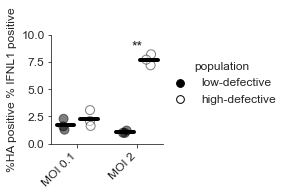

In [12]:
graph = data.loc[data.HA_positive,].groupby(['sample', 'treatment','replicate']).mean().reset_index()


fig,ax = plt.subplots(figsize=(2,2))

graph['IFNL1_positive'] = graph.IFNL1_positive*100
#compare defective amount as hue faceted across infection amounts
sns.stripplot(x='treatment', y='IFNL1_positive', data=graph,  edgecolor='black', order = ['Low', 'High'],
            jitter=True, dodge=True, linewidth=1, s=9, hue="sample", hue_order=['lowDI', 'HiDI'],palette=['0','1'], ax=ax, clip_on=False, alpha=0.5)


sns.despine()
plt.ylim(0,10)
handles, labels = ax.get_legend_handles_labels()


ax.legend(handles[0:2], ['low-defective','high-defective'], bbox_to_anchor=(1, 0.8), loc=2, borderaxespad=0.,frameon=False, title='population')

plt.ylabel('%HA positive % IFNL1 positive')
a =plt.xticks(np.arange(0,2,1),['MOI 0.1', 'MOI 2'],rotation=45, ha='right')

plt.xlabel('')

for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')
        
pvals = []
for position, condition in enumerate(['Low', 'High']):
    curr = graph[graph['treatment'] == condition]
    tstat, pval = stats.ttest_ind(curr[curr['sample'] == 'HiDI'].IFNL1_positive, curr[curr['sample'] == 'lowDI'].IFNL1_positive )
    pvals += [pval]
    
    y = curr[curr['sample'] == 'lowDI'].IFNL1_positive.mean()
    plt.plot([position-0.35, position-0.05], [y, y], lw=4, c='k', zorder=8)
    y = curr[curr['sample'] == 'HiDI'].IFNL1_positive.mean()
    plt.plot([position+0.05, position+0.35], [y, y], lw=4, c='k', zorder=8, clip_on=False)  
pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
for position, val in enumerate(pvals):
    if val:
        y = graph[graph['treatment'] == ['Low', 'High'][position]].IFNL1_positive.max()
        plt.text(position, y, "**", ha='center', va='bottom', fontsize=14)
plt.savefig('Figures/MOIdefectivecontent.pdf', format='pdf', bbox_inches = "tight")

Not due to differences in total fraction of infected cells.

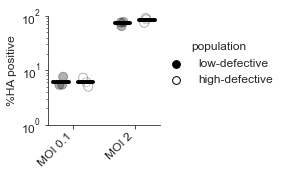

In [13]:
graph = data.groupby(['sample', 'treatment','replicate']).mean().reset_index()


fig,ax = plt.subplots(figsize=(2,2))

graph['HA_positive'] = graph.HA_positive*100
#compare defective amount as hue faceted across infection amounts
sns.stripplot(x='treatment', y='HA_positive', data=graph,  edgecolor='black', order = ['Low', 'High'],
            jitter=True, dodge=True, linewidth=1, s=9, hue="sample", hue_order=['lowDI', 'HiDI'],palette=['0','1'], ax=ax, clip_on=False, alpha=0.3)
plt.yscale('log')
sns.despine()
handles, labels = ax.get_legend_handles_labels()


ax.legend(handles[0:2], ['low-defective','high-defective'], bbox_to_anchor=(1, 0.8), loc=2, borderaxespad=0.,frameon=False, title='population')

plt.ylabel('%HA positive')
a =plt.xticks(np.arange(0,2,1),['MOI 0.1', 'MOI 2'],rotation=45, ha='right')
plt.ylim(1,100)
plt.xlabel('')

for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')
        
pvals = []
for position, condition in enumerate(['Low', 'High']):
    curr = graph[graph['treatment'] == condition]
    tstat, pval = stats.ttest_ind(curr[curr['sample'] == 'HiDI'].HA_positive, curr[curr['sample'] == 'lowDI'].HA_positive )
    pvals += [pval]
    y = curr[curr['sample'] == 'lowDI'].HA_positive.mean()
    plt.plot([position-0.325, position-0.075], [y, y], lw=4, c='k', zorder=8)
    y = curr[curr['sample'] == 'HiDI'].HA_positive.mean()
    plt.plot([position+0.075, position+0.325], [y, y], lw=4, c='k', zorder=8, clip_on=False)  
pvals  = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
for position, val in enumerate(pvals):
    if val:
        y = graph[graph['treatment'] == ['Low', 'High'][position]].HA_positive.max()
        plt.text(position, y, "**", ha='center', va='bottom', fontsize=14)
plt.savefig('Figures/MOIdefectivecontentHA.pdf', format='pdf', bbox_inches = "tight")